In [73]:
import os
import sys
import pandas as pd
import nibabel as nb
import nibabel as nib
import numpy as np
import nilearn
import matplotlib.pyplot as plt
from nilearn.plotting import plot_roi, plot_stat_map
from nilearn import datasets, plotting, regions
import nimare
from nimare import meta
from nimare.dataset import Dataset
from nimare.decode import discrete
from nimare.io import convert_neurosynth_to_dataset
from nimare.utils import get_resource_path
sys.path.append('../modeling')
from modeling_utils import get_feature_regions
from wordcloud import WordCloud

In [2]:
datasets = nimare.extract.fetch_neurosynth()
neurosynth_db = datasets[0]

INFO:nimare.extract.utils:Dataset found in /Users/VictoriaShevchenko/.nimare/neurosynth

INFO:nimare.extract.extract:Searching for any feature files matching the following criteria: [('data-neurosynth', 'version-7')]


File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.
File exists and overwrite is False. Skipping.


In [3]:
neurosynth_dset = convert_neurosynth_to_dataset(
    coordinates_file=neurosynth_db["coordinates"],
    metadata_file=neurosynth_db["metadata"],
    annotations_files=neurosynth_db["features"],
    
)
neurosynth_dset.save("neurosynth_dataset.pkl")

KeyboardInterrupt: 

In [13]:
neurosynth_dset = Dataset.load("neurosynth_dataset.pkl")

In [14]:
schaefer_map = nilearn.datasets.fetch_atlas_schaefer_2018(1000, yeo_networks = 7)
schaefer_map = nb.load(schaefer_map['maps'])

In [15]:
best_features = pd.read_csv(f"../modeling/best_features/100_best_features.csv")
regions_kept = get_feature_regions(best_features, False)
regions_kept = np.where(regions_kept != 0)[0] + 1
roi = np.zeros_like(schaefer_map.get_fdata())

In [16]:
for region in regions_kept:
    indices = np.where(schaefer_map.get_fdata() == region)
    roi[indices] = 1

In [17]:
roi.shape

(182, 218, 182)

In [18]:
roi_img = nib.Nifti1Image(roi, schaefer_map.affine)

In [19]:
ns_roi = nilearn.image.resample_to_img(roi_img, neurosynth_dset.masker.mask_img, interpolation='nearest')


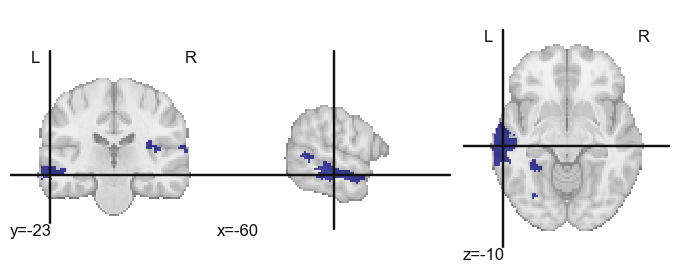

In [20]:
plot_roi(ns_roi)

In [21]:
decoder = discrete.NeurosynthDecoder()
decoder.fit(neurosynth_dset)

In [22]:
ids_use = neurosynth_dset.get_studies_by_mask(ns_roi)

In [23]:
decode_df = decoder.transform(ids=ids_use)

In [24]:
decode_df = decode_df.sort_values(by="probReverse", ascending=False)

In [25]:
sorted_terms = decode_df.index

In [26]:
sorted_terms = np.array([term.replace('terms_abstract_tfidf__','') for term in sorted_terms])

In [27]:
decode_df.index = sorted_terms

In [56]:
import re
text =  " ".join(sorted_terms)
text = text.replace(" cortex", "")
text = text.replace(" gyrus", "")
text = text.replace(" posterior", "")
text = text.replace(" anterior", "")
text = text.replace(" parietal", "")
text = text.replace(" frontal", "")
text = text.replace(" temporal", "")
text = text.replace(" dorsal", "")
text = text.replace(" functional", "")

text = re.sub(r"\d+", "", text)
text = re.sub(r"LDA_", "", text)
text = text.replace("__", "")
text = text.replace("_", " ")
text = text.replace("  ", " ")




In [135]:
def term_cloud(text, exclude, colormap, single_color_func, max_font_size, background_color = None, save_to = None):
    if single_color_func is not None:
        from wordcloud import get_single_color_func
        color_func = get_single_color_func(single_color_func)
    for word in exclude:
        text = text.replace(word, "")
    wordcloud = WordCloud(max_font_size=max_font_size, background_color = background_color, colormap = colormap, relative_scaling = 1, color_func = color_func).generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    if save_to is not None:
        wordcloud.to_file(save_to)

In [129]:
cog_terms = open(f"cog_terms/100_best_features_cog_terms.txt", "r")
cog_terms = cog_terms.read()
exclude = ["cortex", "gyrus", "posterior", "anterior", "parietal", "frontal", "temporal", "dorsal", "functional", "lateral", "medial", "network", "saggital", "prefrontal", "frontal", "task", "abstract", "weight", "pre", "inferior", "superior", "cingulate", "occipital", "ventral", "lobule", "middle", "insula", "amygdala", " s "]

In [131]:
!pwd

/Users/VictoriaShevchenko/Documents/PhD/SCZ/neurosynth


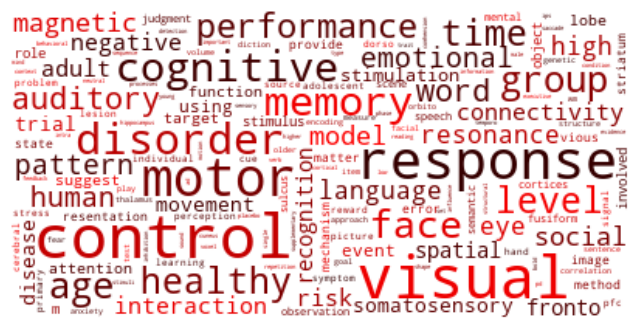

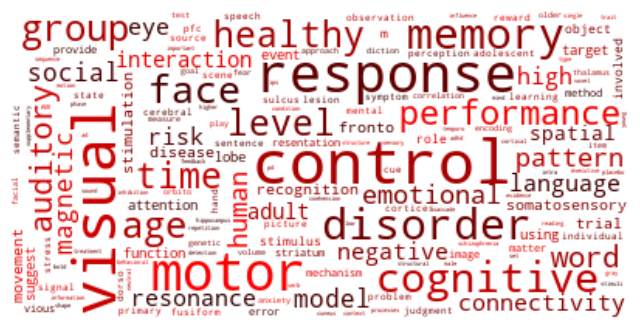

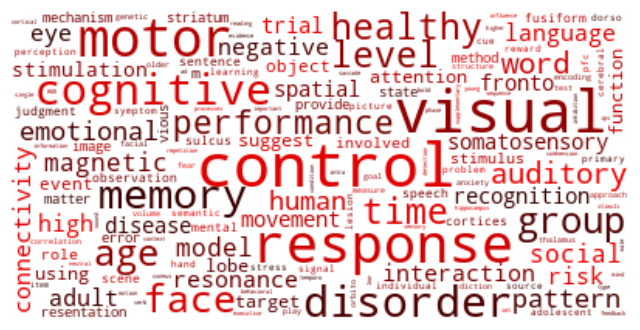

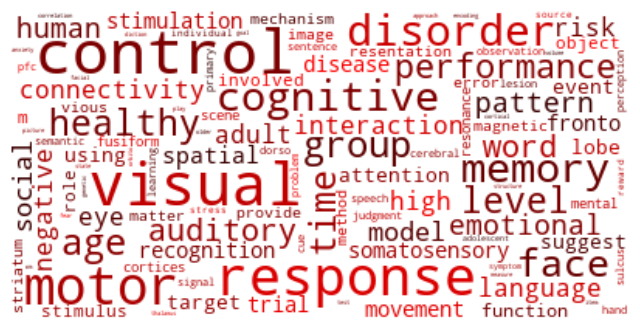

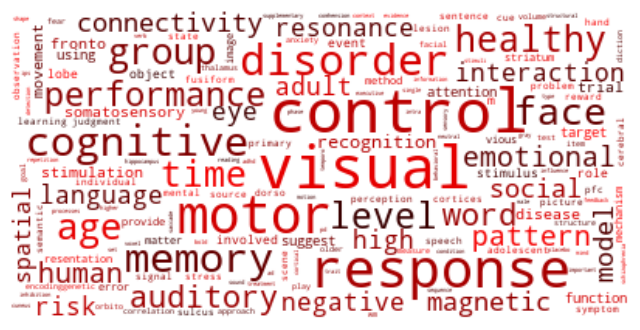

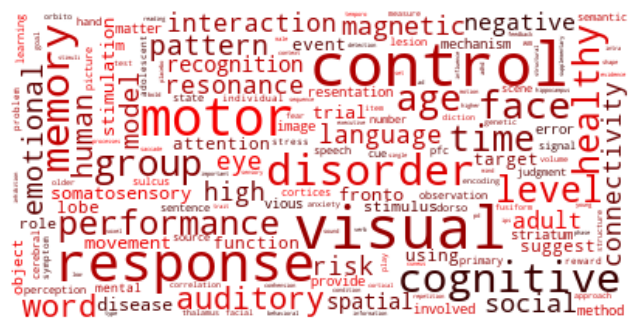

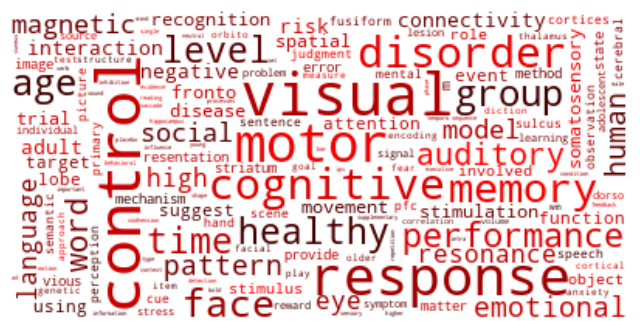

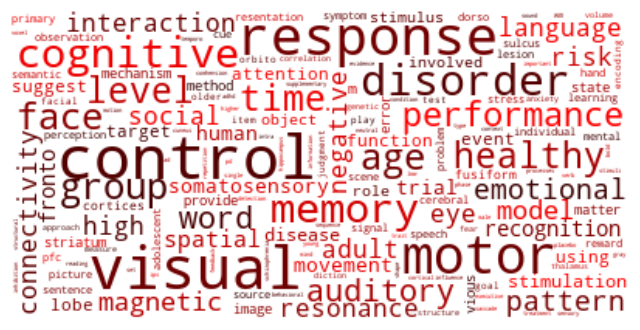

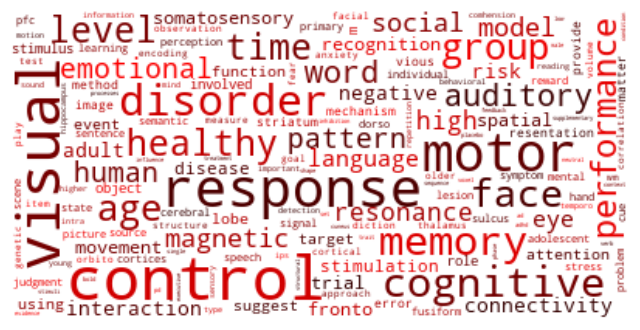

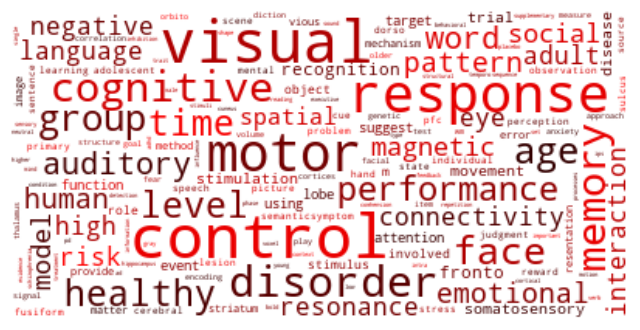

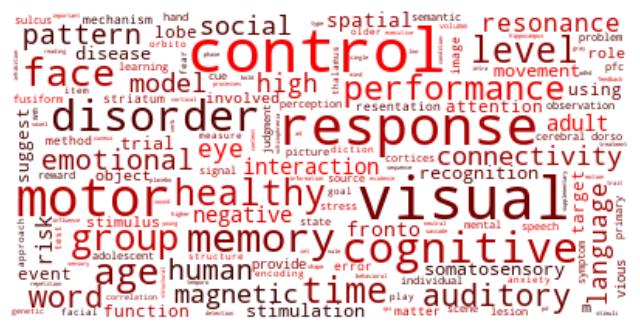

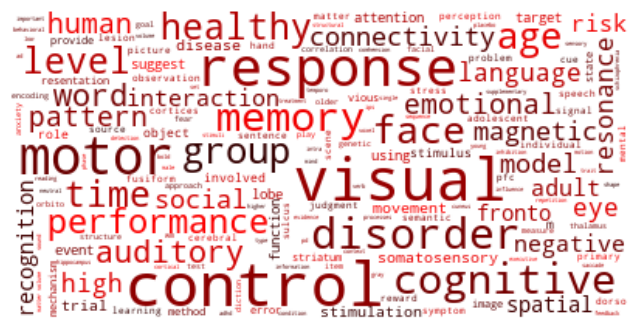

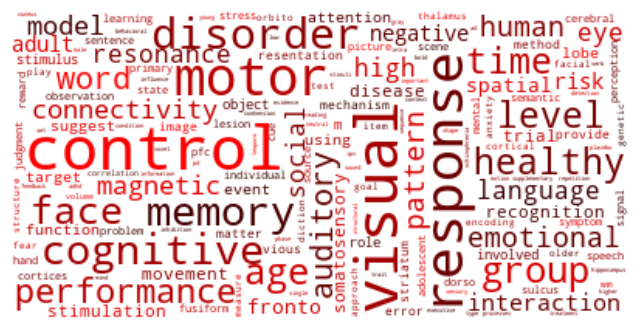

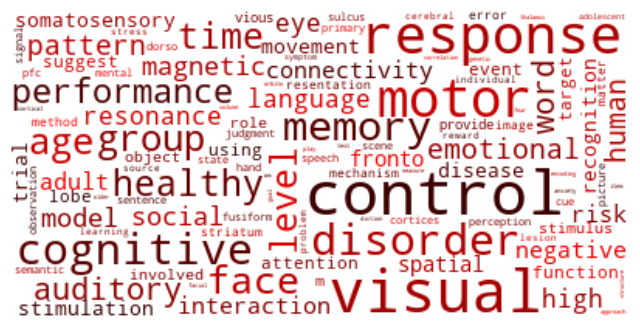

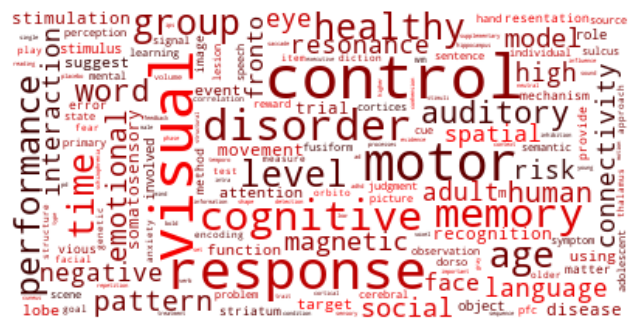

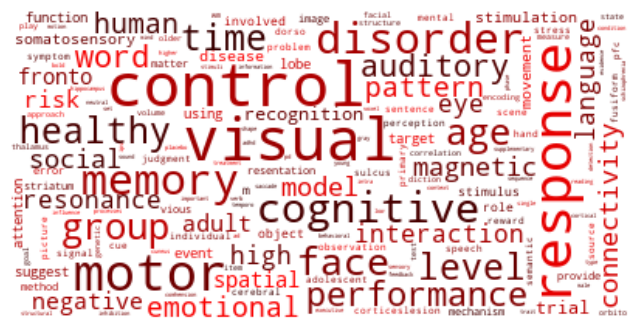

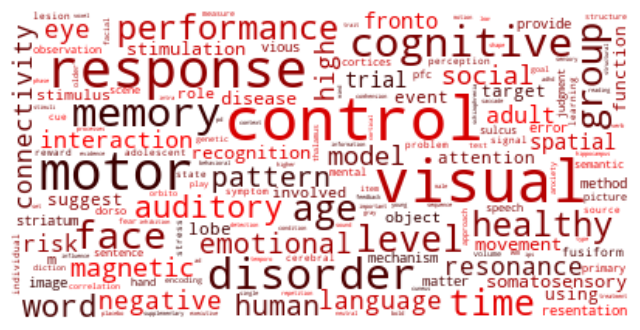

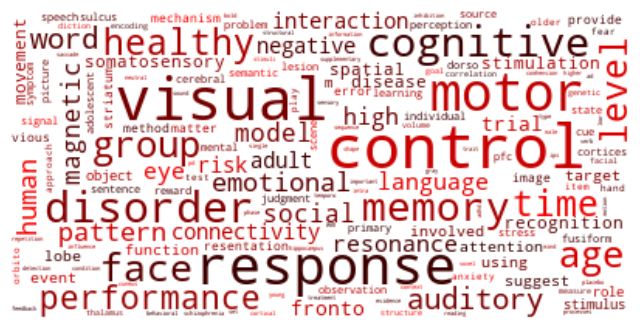

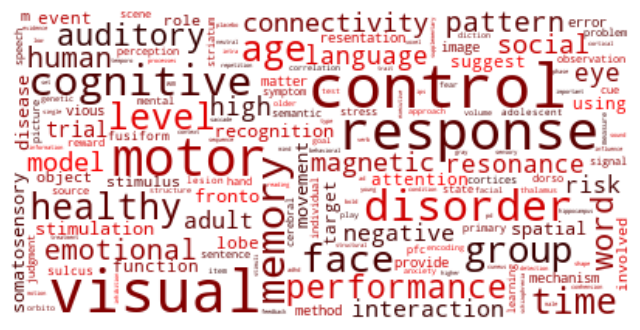

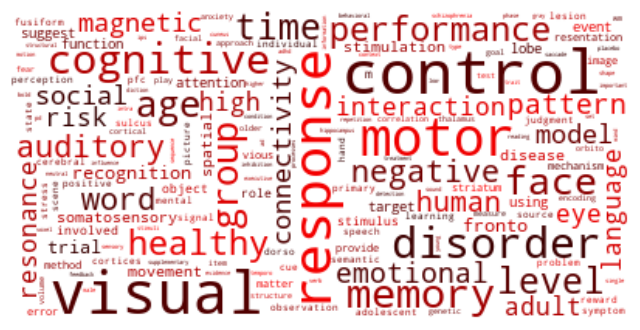

FileNotFoundError: [Errno 2] No such file or directory: 'cog_terms/10000_best_features_cog_terms.txt'

In [136]:
n_features = np.loadtxt("n_features.txt", dtype=str)
exclude = ["cortex", "gyrus", "posterior", "anterior", "parietal", "frontal", "temporal", "dorsal", "functional", "lateral", "medial", "network", "saggital", "prefrontal", "frontal", "task", "abstract", "weight", "pre", "inferior", "superior", "cingulate", "occipital", "ventral", "lobule", "middle", "insula", "amygdala", " s "]

for n in n_features:
    cog_terms = open(f"cog_terms/{n}_best_features_cog_terms.txt", "r")
    cog_terms = cog_terms.read()
    term_cloud(cog_terms, exclude = exclude, colormap = None, max_font_size = 40, background_color = "white", single_color_func =  "#650000", save_to = f"../../figures/wordclouds/{n}_best_features_wordcloud.png")


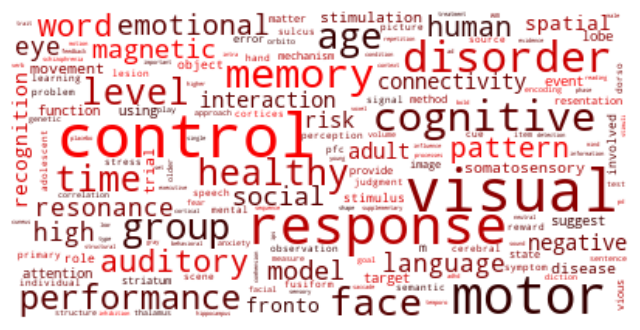

In [125]:
term_cloud(cog_terms, exclude = exclude, colormap = None, max_font_size = 40, background_color = "white", single_color_func =  "#650000")

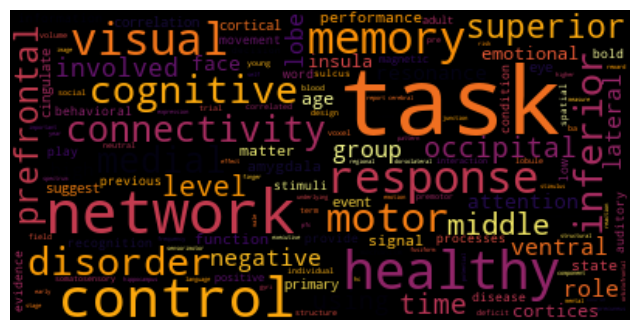

In [34]:
wordcloud = WordCloud(max_font_size=60, background_color = None, colormap = "inferno", relative_scaling = 1).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
wordcloud = WordCloud(max_font_size=60, background_color = None, colormap = "inferno", relative_scaling = 1).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()